In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
DATA_DIR = "./data"

In [95]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

train_df.columns = ["_".join(column.split(" ")) for column in train_df.columns]
test_df.columns = ["_".join(column.split(" ")) for column in test_df.columns]

train_df.head()

,id,Product_ID,Type,Air_temperature_[K],Process_temperature_[K],Rotational_speed_[rpm],Torque_[Nm],Tool_wear_[min],Machine_failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [96]:
len(train_df), len(test_df)

(136429, 90954)

In [97]:
train_df[["Product_ID", "Type"]].value_counts()

Product_ID  Type
L53257      L       139
L53271      L       131
L49056      L       131
L48892      L       120
L54275      L       120
                   ... 
M18364      M         1
M18491      M         1
M18670      M         1
M18727      M         1
M24859      M         1
Length: 9976, dtype: int64

In [98]:
train_corr = train_df.corr()
train_corr

/tmp/ipykernel_65036/3347955815.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_corr = train_df.corr()


,id,Air_temperature_[K],Process_temperature_[K],Rotational_speed_[rpm],Torque_[Nm],Tool_wear_[min],Machine_failure,TWF,HDF,PWF,OSF,RNF
id,1.000000,-0.005338,-0.002396,0.004419,-0.001968,-0.001790,0.001500,-0.000475,-0.000680,0.003275,0.002114,0.000175
Air_temperature_[K],-0.005338,1.000000,0.856080,0.016545,-0.006773,0.016994,0.067744,0.003826,0.100454,0.007967,0.007842,0.004815
Process_temperature_[K],-0.002396,0.856080,1.000000,0.011263,-0.006298,0.012777,0.030966,0.004459,0.041454,0.003871,0.005337,0.004399
Rotational_speed_[rpm],0.004419,0.016545,0.011263,1.000000,-0.779394,0.003983,-0.060868,-0.005765,-0.081996,0.053948,-0.061376,-0.003410
Torque_[Nm],-0.001968,-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.145793,0.012983,0.100773,0.050289,0.108765,0.007986
Tool_wear_[min],-0.001790,0.016994,0.012777,0.003983,-0.003148,1.000000,0.056448,0.046470,0.011709,0.007624,0.063604,-0.002071
Machine_failure,0.001500,0.067744,0.030966,-0.060868,0.145793,0.056448,1.000000,0.311919,0.564507,0.383941,0.494668,0.001428
TWF,-0.000475,0.003826,0.004459,-0.005765,0.012983,0.046470,0.311919,1.000000,0.010145,0.039927,0.036041,0.002044
HDF,-0.000680,0.100454,0.041454,-0.081996,0.100773,0.011709,0.564507,0.010145,1.000000,0.046680,0.067149,0.000885
PWF,0.003275,0.007967,0.003871,0.053948,0.050289,0.007624,0.383941,0.039927,0.046680,1.000000,0.090016,0.000827


<Axes: >

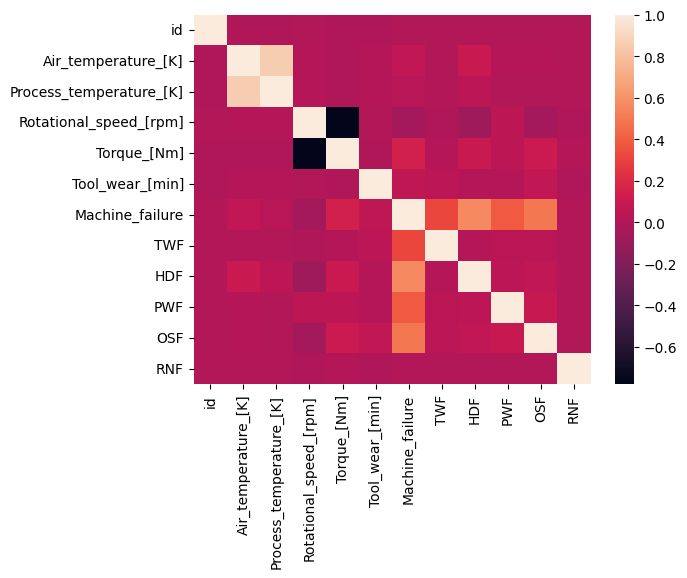

In [99]:
sns.heatmap(train_corr)

0    134281
1      2148
Name: Machine_failure, dtype: int64

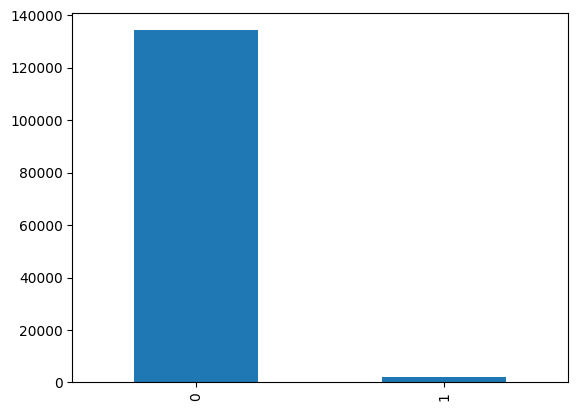

In [100]:
failure_counts = train_df.Machine_failure.value_counts()
failure_counts.plot.bar()
failure_counts

<Axes: >

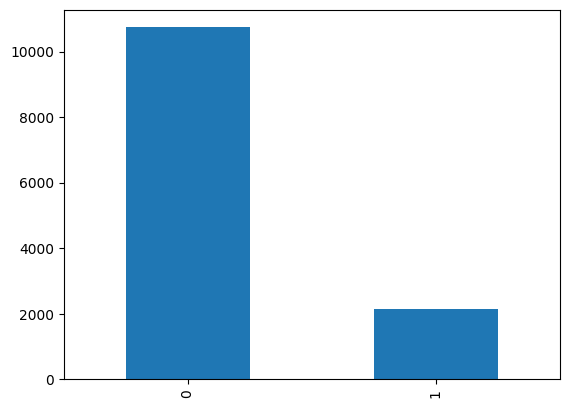

In [101]:
train_df_no_failure = train_df.query("Machine_failure == 0")
train_df_failure = train_df.query("Machine_failure == 1")

train_df_balanced = pd.concat((train_df_no_failure.iloc[:len(train_df_failure) * 5], train_df_failure))
train_df_balanced.Machine_failure.value_counts().plot.bar()

## Dataset

In [102]:
train_df, val_df = train_test_split(train_df_balanced, test_size=0.2)

In [103]:
class MachineFailureDataset(torch.utils.data.Dataset):
    def __init__(self, feature_df: pd.DataFrame, label_df: pd.DataFrame):
        super(MachineFailureDataset, self).__init__()
        self.features = torch.tensor(feature_df.values, dtype=torch.float32)
        self.labels = torch.tensor(label_df.values, dtype=torch.float32)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.labels)
    
cols = ["OSF", "PWF", "HDF", "TWF"]

train_ds = MachineFailureDataset(feature_df=train_df[cols], label_df=train_df["Machine_failure"])
val_ds = MachineFailureDataset(feature_df=val_df[cols], label_df=val_df["Machine_failure"])

train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=True)

In [147]:
class MachineFailureModel(nn.Module):
    def __init__(self, input_size: int):
        super(MachineFailureModel, self).__init__()
        self.linear_1 = nn.Linear(in_features=input_size, out_features=512)
        self.linear_2 = nn.Linear(in_features=self.linear_1.out_features, out_features=256)
        self.linear_3 = nn.Linear(in_features=self.linear_2.out_features, out_features=128)
        self.output = nn.Linear(in_features=self.linear_3.out_features, out_features=1)

    def forward(self, x):
        x = nn.functional.relu(self.linear_1(x))
        x = nn.functional.dropout(x)
        x = nn.functional.relu(self.linear_2(x))
        x = nn.functional.dropout(x)
        x = nn.functional.relu(self.linear_3(x))
        x = nn.functional.sigmoid(self.output(x))
        return x

In [148]:
model = MachineFailureModel(input_size=len(cols))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
weight = torch.tensor([50.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=weight)

In [150]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
EPOCHS = 100

for epoch in range(EPOCHS):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        train_acc.append(np.sum(np.array(torch.round(outputs) == labels)) / len(labels))

    
    model.eval()
    for i, data in enumerate(val_dataloader, 0):
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        val_loss.append(loss.item())
        val_acc.append(np.sum(np.array(torch.round(outputs) == labels)) / len(labels))

    print(f"Epoch {epoch} - Train loss: {np.mean(train_loss)}, Train accuracy: {np.mean(train_acc)}, Val loss: {np.mean(val_loss)}, Val accuracy: {np.mean(val_acc)}")

print('Finished Training')

Epoch 0 - Train loss: 0.9183787072406095, Train accuracy: 0.9595588235294118, Val loss: 0.838674404003002, Val accuracy: 1.0
Epoch 1 - Train loss: 0.9191108543437332, Train accuracy: 0.9595588235294118, Val loss: 1.1297278183477897, Val accuracy: 1.0
Epoch 2 - Train loss: 0.919540898718701, Train accuracy: 0.9591395768833849, Val loss: 1.3007721694899195, Val accuracy: 0.8333333333333331
Epoch 3 - Train loss: 0.9180127887902984, Train accuracy: 0.9595588235294118, Val loss: 0.6931473561275152, Val accuracy: 1.0
Epoch 4 - Train loss: 0.918013423958061, Train accuracy: 0.9595588235294118, Val loss: 0.6931472979945901, Val accuracy: 1.0
Epoch 5 - Train loss: 0.9180125651344795, Train accuracy: 0.9595588235294118, Val loss: 0.6931472516354219, Val accuracy: 1.0
Epoch 6 - Train loss: 0.9183784762034106, Train accuracy: 0.9595588235294118, Val loss: 0.8386740846398436, Val accuracy: 1.0
Epoch 7 - Train loss: 0.9183784680838925, Train accuracy: 0.9595588235294118, Val loss: 0.8386740618281894

## Submission

In [78]:
test_df["Machine_failure"] = -1

test_ds = MachineFailureDataset(feature_df=test_df[cols], label_df=test_df["Machine_failure"])
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [79]:
model.eval()

predictions = []

for data in test_dataloader:
    inputs, labels = data
    output = model(inputs)
    predictions.append(output.item())

predictions = np.round(np.array(predictions))

In [80]:
submission_df = pd.DataFrame(test_df["id"])
submission_df["Machine failure"] = predictions.astype(np.int64)
submission_df.head()

,id,Machine failure
0,136429,0
1,136430,0
2,136431,0
3,136432,0
4,136433,0


In [81]:
submission_df.to_csv("./submission.csv", index=False)